In [1]:
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax import grad, jacobian, vmap, random, hessian, jit
from jax.scipy.linalg import solve_triangular
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# kernel + derivative fcns
def rbf(gamma):
    def kernel(x, y):
        return jnp.exp(-gamma*jnp.sum((x-y)**2))
    return kernel

def lap(f, argnums):
    hess = jit(hessian(f, argnums=argnums))  # cache compilation
    @jit
    def laplacian(x, y):
        return jnp.trace(hess(x, y))
    return laplacian

def check_lap(u):
    def lap(x):
        return jnp.trace(hessian(u)(x))
    return jit(vmap(lap, in_axes=0))

k = rbf(17)

vec_k = vmap(vmap(k, (None, 0)), (0, None)) 
lapx = lap(k, argnums=0) # laplacian wrt to first input x
lapx_lapy = lap(lapx, argnums=1) # laplacian wrt to second input y
vec_lapx = vmap(vmap(lapx, in_axes = (None,0)), in_axes=(0, None)) 
vec_lapx_lapy = vmap(vmap(lapx_lapy, in_axes = (None,0)), in_axes = (0, None))


In [3]:
def u(x, y):
    return -jnp.sin(6*jnp.pi * x) * jnp.sin(4*jnp.pi * y) + 8*jnp.cos(2*jnp.pi * x+y)

def f(x, y):
    def u_1(xy):
        return u(xy[0], xy[1])
    laplacian = jnp.trace(hessian(u_1)(jnp.array([x, y]))) 
    return laplacian

def g_dir(x, y): return u(x, y)

f_vec = vmap(f, in_axes=(0, 0))
g_dir_vec = vmap(g_dir, in_axes=(0, 0))

In [4]:
# Test grid
xmin, xmax = 0, 1
ymin, ymax = 0, 1
n_eval = 100

x, y = jnp.linspace(xmin, xmax, n_eval), jnp.linspace(ymin, ymax, n_eval)
X, Y = jnp.meshgrid(x, y)
X_test = jnp.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)

u_exact = u(X_test[:, 0], X_test[:, 1])
f_exact = f_vec(X_test[:,0], X_test[:, 1]) 


In [5]:
# Compute errors for uniform random collocation points
def random_points(xmin, xmax, ymin, ymax, I, B):
    # Interior points: uniform in full domain
    X_int = np.random.uniform(low=[xmin, ymin], high=[xmax, ymax], size=(I, 2))

    # Boundary points
    X_bdy = np.empty((B, 2))
    for i in range(B):
        side = np.random.choice(4)
        t = np.random.rand()
        if side == 0:      # bottom: (t, ymin)
            X_bdy[i] = [xmin + t * (xmax - xmin), ymin]
        elif side == 1:    # right: (xmax, t)
            X_bdy[i] = [xmax, ymin + t * (ymax - ymin)]
        elif side == 2:    # top: (t, ymax)
            X_bdy[i] = [xmin + t * (xmax - xmin), ymax]
        else:              # left: (xmin, t)
            X_bdy[i] = [xmin, ymin + t * (ymax - ymin)]

    return X_int, X_bdy

def sample_int():
    return np.random.rand(2)

def sample_bdy():
    side = np.random.choice(4)
    t = np.random.rand()
    if side == 0:      # bottom edge: (t, 0)
        return np.array([t, 0.0])
    elif side == 1:    # right edge: (1, t)
        return np.array([1.0, t])
    elif side == 2:    # top edge: (t, 1)
        return np.array([t, 1.0])
    else:              # left edge: (0, t)
        return np.array([0.0, t])

unif_errs_lap = []
unif_errs_u = []
X_int_list=[]
X_bdy_list=[]


for i in range(1, 126):
    new_int = sample_int()
    X_int_list.append(new_int)

    # Add one new boundary point every 5 iterations
    if i % 5 == 0:
        new_bdy = sample_bdy()
        X_bdy_list.append(new_bdy)

    # Convert lists to arrays
    X_int = np.array(X_int_list)
    X_bdy = np.array(X_bdy_list) if X_bdy_list else np.empty((0, 2))

    K_11 = vec_lapx_lapy(X_int, X_int)
    K_12 = vec_lapx(X_int, X_bdy)
    K_21 = jnp.copy(K_12).T
    K_22 = vec_k(X_bdy, X_bdy)

    K = jnp.block([
        [K_11, K_12],
        [K_21, K_22]
        ])
    
    f_int = f_vec(X_int[:,0], X_int[:,1])  
    g_bdy = g_dir_vec(X_bdy[:,0], X_bdy[:,1]) 
    f_rhs = jnp.hstack([f_int, g_bdy])
    alpha = jnp.linalg.solve(K + 1e-9*jnp.eye(K.shape[0]), f_rhs)

    def u_est_fcn(x):
        basis = jnp.hstack([vec_lapx(x.reshape(1, -1), X_int), vec_k(x.reshape(1, -1), X_bdy)])
        return (basis @ alpha).squeeze()

    vec_u_est = vmap(u_est_fcn, in_axes=0)

    u_est = vec_u_est(X_test)

    lap_u = check_lap(u_est_fcn)
    lap_u_est = lap_u(X_test)


    unif_errs_lap.append(np.linalg.norm(lap_u_est - f_exact)/ np.linalg.norm(f_exact))

    unif_errs_u.append(np.linalg.norm((u_est - u_exact)) / np.linalg.norm(u_exact))


In [6]:
def rpcq_square_bdy(num_int, num_bdy, k_int, k_int_bdy, k_bdy, sample_int, sample_bdy):
    L = jnp.zeros((num_int + num_bdy, num_int + num_bdy))
    S = []  # list of selected 2D points
    i = 0
    trial = 0
    k_int_vec = vmap(k_int, in_axes=(0, None))
    k_bdy_vec = vmap(k_bdy, in_axes=(0, None))
    k_int_bdy_vec = vmap(k_int_bdy, in_axes=(0, None))


    while i < num_int:
        trial += 1
        # Sample point uniformly from [0, 1]^2
        xi = sample_int()

        if len(S) == 0:
            d = k_int(xi, xi)
            c = jnp.array([])
        else:
            Xs = jnp.stack(S)
            Ks_si = k_int_vec(Xs, xi)
            c = solve_triangular(L[:i, :i], Ks_si, lower=True)
            d = k_int(xi, xi) - jnp.dot(c, c)

        # Rejection sampling
        U = np.random.rand()
        if U < d / k_int(xi, xi):
            print("Int. point",i + 1, ":", trial, "trials")
            S.append(xi)
            L = L.at[i, :i].set(c)
            L = L.at[i, i].set(jnp.sqrt(d))
            i += 1
            trial = 0
    
    while i < num_int + num_bdy:
        trial += 1
        xi = sample_bdy()
        Xs = jnp.stack(S)
        # Evaluate cross-kernel entries
        K_int_part = k_int_bdy_vec(Xs[:num_int], xi)
        K_bdy_part = k_bdy_vec(Xs[num_int:i], xi)
        Ks_si = jnp.concatenate([K_int_part, K_bdy_part])
        c = solve_triangular(L[:i, :i], Ks_si, lower=True)
        d = k_bdy(xi, xi) - jnp.dot(c, c)

        # Rejection sampling
        U = np.random.rand()
        if U < d / k_bdy(xi, xi):
            print("Bdy. point",i - num_int + 1, ":", trial, "trials")
            S.append(xi)
            L = L.at[i, :i].set(c)
            L = L.at[i, i].set(jnp.sqrt(d))
            i += 1
            trial = 0

    X_int = S[:num_int]
    X_bdy = S[num_int:]

    return L, jnp.array(X_int), jnp.array(X_bdy)

In [7]:
num_int=125
num_bdy = 25
L, S_int, S_bdy = rpcq_square_bdy(num_int, num_bdy, lapx_lapy, lapx, k, sample_int, sample_bdy)

Int. point 1 : 1 trials
Int. point 2 : 1 trials
Int. point 3 : 1 trials
Int. point 4 : 1 trials
Int. point 5 : 1 trials
Int. point 6 : 1 trials
Int. point 7 : 1 trials
Int. point 8 : 2 trials
Int. point 9 : 1 trials
Int. point 10 : 1 trials
Int. point 11 : 1 trials
Int. point 12 : 2 trials
Int. point 13 : 1 trials
Int. point 14 : 1 trials
Int. point 15 : 2 trials
Int. point 16 : 4 trials
Int. point 17 : 2 trials
Int. point 18 : 1 trials
Int. point 19 : 2 trials
Int. point 20 : 2 trials
Int. point 21 : 2 trials
Int. point 22 : 2 trials
Int. point 23 : 4 trials
Int. point 24 : 1 trials
Int. point 25 : 2 trials
Int. point 26 : 1 trials
Int. point 27 : 2 trials
Int. point 28 : 2 trials
Int. point 29 : 4 trials
Int. point 30 : 2 trials
Int. point 31 : 1 trials
Int. point 32 : 2 trials
Int. point 33 : 4 trials
Int. point 34 : 1 trials
Int. point 35 : 1 trials
Int. point 36 : 2 trials
Int. point 37 : 6 trials
Int. point 38 : 7 trials
Int. point 39 : 13 trials
Int. point 40 : 8 trials
Int. poi

In [8]:
# Compute errors for rpcq collocation points
rpcq_errs_lap = []
rpcq_errs_u = []

for i in range(1, num_int + 1):

    n_int_i = i   
    n_bdy_i = i // 5

    X_int_i = S_int[:n_int_i, :]
    X_bdy_i = S_bdy[:n_bdy_i, :]
    
    L_idx = np.concatenate((np.arange(0, n_int_i), np.arange(num_int, num_int + n_bdy_i)))

    L_i = L[L_idx, :]
    
    f_int = f_vec(X_int_i[:,0], X_int_i[:,1])  
    g_bdy = g_dir_vec(X_bdy_i[:,0], X_bdy_i[:,1]) 
    f_rhs = jnp.hstack([f_int, g_bdy])


    alpha = jnp.linalg.solve(L_i @ L_i.T + 1e-9*jnp.eye(L_i.shape[0]), f_rhs)

    def u_est_fcn(x):
        basis = jnp.hstack([vec_lapx(x.reshape(1, -1), X_int_i), vec_k(x.reshape(1, -1), X_bdy_i)])
        return (basis @ alpha).squeeze()

    vec_u_est = vmap(u_est_fcn, in_axes=0)

    u_est = vec_u_est(X_test)

    lap_u = check_lap(u_est_fcn)
    lap_u_est = lap_u(X_test)


    rpcq_errs_lap.append(np.linalg.norm(lap_u_est - f_exact)/ np.linalg.norm(f_exact))
    rpcq_errs_u.append(np.linalg.norm((u_est - u_exact)) / np.linalg.norm(u_exact))
    

In [9]:
unif_errs_lap1 = np.array(unif_errs_lap)
unif_errs_u1 = np.array(unif_errs_u)

rpcq_errs_lap1 = np.array(rpcq_errs_lap)
rpcq_errs_u1 = np.array(rpcq_errs_u)

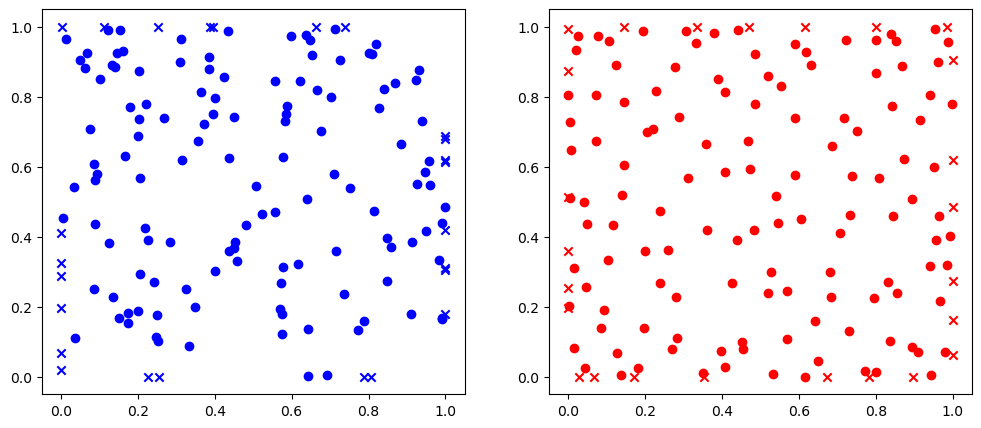

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
axs[0].scatter(X_int[:, 0], X_int[:, 1], color="blue")
axs[0].scatter(X_bdy[:, 0], X_bdy[:, 1], color="blue", marker='x')
axs[1].scatter(S_int[:, 0], S_int[:, 1], color="red")
axs[1].scatter(S_bdy[:, 0], S_bdy[:, 1], color="red", marker='x')


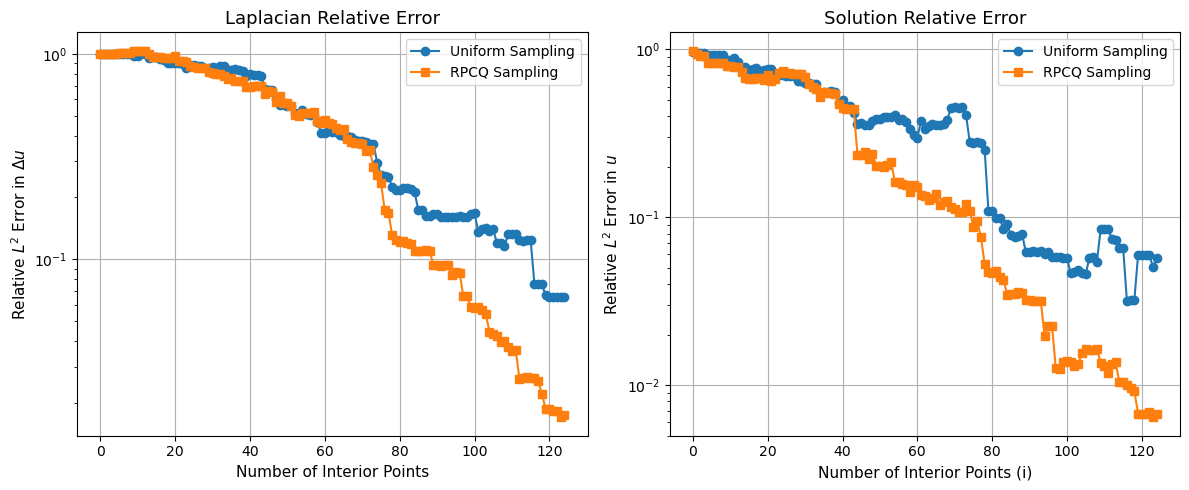

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Subplot 1: Laplacian Error
axs[0].plot(unif_errs_lap1, marker='o', label='Uniform Sampling')
axs[0].plot(rpcq_errs_lap1, marker='s', label='RPCQ Sampling')
axs[0].set_xlabel('Number of Interior Points', fontsize=11)
axs[0].set_ylabel('Relative $L^2$ Error in $\\Delta u$', fontsize=11)
axs[0].set_title('Laplacian Relative Error', fontsize=13)
# axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[0].grid(True)
axs[0].legend()

# Subplot 2: Solution Error
axs[1].plot(unif_errs_u, marker='o', label='Uniform Sampling')
axs[1].plot(rpcq_errs_u, marker='s', label='RPCQ Sampling')
axs[1].set_xlabel('Number of Interior Points (i)', fontsize=11)
axs[1].set_ylabel('Relative $L^2$ Error in $u$', fontsize=11)
axs[1].set_title('Solution Relative Error', fontsize=13)
axs[1].grid(True)
axs[1].legend()
# axs[1].set_xscale('log')
axs[1].set_yscale('log')


plt.tight_layout()
plt.show()